In [1]:
import datacube
dc = datacube.Datacube(app="List Products")

In [2]:
area_json = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              149.2719268798828,
              -35.217575569215505
            ],
            [
              149.5095062255859,
              -35.217575569215505
            ],
            [
              149.5095062255859,
              -34.97543887925878
            ],
            [
              149.2719268798828,
              -34.97543887925878
            ],
            [
              149.2719268798828,
              -35.217575569215505
            ]
          ]
        ]
      }
    }
  ]
}



In [3]:
lons, lats = zip(*area_json["features"][0]["geometry"]["coordinates"][0])

In [4]:
lat_extents = (min(lats), max(lats))
lon_extents = (min(lons), max(lons))

print("Lat:", lat_extents, "\n"
      "Lon:", lon_extents)

Lat: (-35.217575569215505, -34.97543887925878) 
Lon: (149.2719268798828, 149.5095062255859)


In [5]:
prods = dc.list_products()

prods[prods["name"].str.contains("s2")]

name                                        description  \
id                                                                           
90      s2a_ard_granule  Sentinel-2A MSI ARD - NBAR NBART and Pixel Qua...   
92  s2a_level1c_granule  Sentinel-2A Level1C - Ortho Rectified Top of A...   
91      s2b_ard_granule  Sentinel-2B MSI ARD - NBAR NBART and Pixel Qua...   
93  s2b_level1c_granule  Sentinel-2B Level1C - Ortho Rectified Top of A...   

   product_type     platform  orbit label  ancillary_quality  sat_path  gsi  \
id                                                                            
90     S2MSIARD  SENTINEL_2A    NaN  None                NaN       NaN  NaN   
92      S2MSI1C  Sentinel-2A    NaN  None                NaN       NaN  NaN   
91     S2MSIARD  SENTINEL_2B    NaN  None                NaN       NaN  NaN   
93      S2MSI1C  Sentinel-2B    NaN  None                NaN       NaN  NaN   

   instrument         ...          time    format  gqa_cep90  sat_row  lat  \
id                    ...                                                    
90        MSI         ...          None   GeoTIFF        NaN      NaN  NaN   
92        MSI         ...          None  JPEG2000        NaN      NaN  NaN   
91        MSI         ...          None   GeoTIFF        NaN      NaN  NaN   
93        MSI         ...          None  JPEG2000        NaN      NaN  NaN   

    gqa_error_message  crs  resolution tile_size  spatial_dimensions  
id                                                                    
90                NaN  NaN         NaN       NaN                 NaN  
92                NaN  NaN         NaN       NaN                 NaN  
91                NaN  NaN         NaN       NaN                 NaN  
93                NaN  NaN         NaN       NaN                 NaN  

[4 rows x 32 columns]

# Load Data

In [6]:
from datetime import datetime

query = dict(   latitude = lat_extents,
                longitude = lon_extents,
                output_crs = "EPSG:3577",
                time = (datetime(2018,1,1), datetime(2019,1,1)),
                resolution = (30,30))

**Scenes**

In [7]:
dss_2a = dc.find_datasets(product="s2a_ard_granule", group_by='solar_day',**query)
scenes_from_a = dc.load(product="s2a_ard_granule", group_by='solar_day',datasets=dss_2a, measurements = ['nbart_blue','nbart_green','nbart_red','nbart_nir_1', 'nbart_swir_2','nbart_swir_3','fmask'],**query)

In [8]:
covered = ((scenes_from_a.fmask!=0).groupby('time').mean()>0.4) # at least 40% covered
scenes_from_a = scenes_from_a.isel(time=covered)

In [9]:
dss_2b = dc.find_datasets(product="s2b_ard_granule", group_by='solar_day',**query)
scenes_from_b = dc.load(product="s2b_ard_granule", group_by='solar_day',datasets=dss_2b,measurements = ['nbart_blue','nbart_green','nbart_red','nbart_nir_1', 'nbart_swir_2','nbart_swir_3','fmask'],**query)

In [10]:
if len(dss_2b)>0:
    covered = ((scenes_from_b.fmask!=0).groupby('time').mean()>0.4) # at least 40% covered
    scenes_from_b = scenes_from_b.isel(time=covered)

In [11]:
scenes = scenes_from_a.merge(scenes_from_b)
scenes = scenes.sortby('time')

In [12]:
del scenes_from_a
del scenes_from_b

In [13]:
bands = {"fmask": "fmask",
         "nbart_blue": "blue",
         "nbart_green": "green",
         "nbart_red": "red",
         "nbart_nir_1": "nir",
         "nbart_swir_2": "swir1",
         "nbart_swir_3": "swir2"}

In [14]:
scenes = scenes.rename(bands)

In [15]:
scenes

<xarray.Dataset>
Dimensions:  (time: 65, x: 836, y: 988)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-05T00:02:29.027000 ... 2018-12-26T00:02:31.024000
  * y        (y) float64 -3.955e+06 -3.955e+06 ... -3.926e+06 -3.926e+06
  * x        (x) float64 1.564e+06 1.564e+06 1.564e+06 ... 1.589e+06 1.589e+06
Data variables:
    blue     (time, y, x) float64 446.0 418.0 487.0 520.0 ... 711.0 720.0 722.0
    green    (time, y, x) float64 568.0 531.0 627.0 677.0 ... 959.0 941.0 939.0
    red      (time, y, x) float64 731.0 627.0 709.0 ... 1.147e+03 1.192e+03
    nir      (time, y, x) float64 1.823e+03 1.703e+03 ... 2.601e+03 2.124e+03
    swir1    (time, y, x) float64 2.473e+03 2.748e+03 ... 4.074e+03 3.164e+03
    swir2    (time, y, x) float64 1.643e+03 1.904e+03 ... 2.943e+03 2.41e+03
    fmask    (time, y, x) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    crs:      EPSG:3577

In [16]:
import numpy as np
#clean_mask = np.isin(scenes.fmask, [1,4,5])
#water_mask = np.isin(scenes.fmask, [4])

# cloud mask

In [17]:
import s2cloudless as s2cl
cloud_detector = s2cl.S2PixelCloudDetector(threshold=0.3, all_bands=False, average_over=4, dilation_size=7)

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [18]:
s2cloudless_bands = ['B01', 'B02', 'B04', 'B05', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']

def get_masks(dss_2a):
    l1c_2a=[]
    for ds in dss_2a:
        full_dataset = dc.index.datasets.get(ds.id, include_sources=True)
        if len(full_dataset.sources['S2MSI1C'].uris)>0:
            l1c_2a.append(full_dataset.sources['S2MSI1C'])

    if len(l1c_2a) != len(dss_2a): return None
    l1c  = dc.load(product=l1c_2a[0].type.name, datasets=l1c_2a, measurements=s2cloudless_bands,
               group_by='solar_day',**query)
    s2obs=l1c[s2cloudless_bands].to_array(dim='band').transpose('time', 'y','x','band').data.astype(np.float32)
    s2obs[s2obs<=0]=np.nan
    s2obs=s2obs/1e4
    s2obs[s2obs>1]=1
    cloud_probs = cloud_detector.get_cloud_masks(s2obs)
    l1c['clean_mask']=('time','y','x'), (cloud_probs==0)

    return l1c['clean_mask'].to_dataset(name='clean_mask').copy()
    

clean_mask = None
s2cloudless = get_masks(dss_2a)
if s2cloudless is None:
    clean_mask = np.isin(scenes.fmask, [1,4,5])
else:
    if len(dss_2b)>0:
        s2cloudless_2b = get_masks(dss_2b)
        if s2cloudless_2b is None:
            clean_mask = np.isin(scenes.fmask, [1,4,5])
        else:
            s2cloudless_clean_mask= s2cloudless.merge(s2cloudless_2b)
    else:
        s2cloudless_clean_mask= s2cloudless

if clean_mask is None:
    clean_mask = s2cloudless_clean_mask.sel(time=scenes.time).clean_mask.values.astype(bool)
    del s2cloudless_clean_mask
    clean_mask = clean_mask & (scenes.fmask!=0).values
    

In [19]:
clean_mask.shape

(65, 988, 836)

### Wofs Classify Code (from AMA)  

In [20]:

import gc
import numpy as np
import xarray as xr

import datacube
# Command line tool imports
import argparse
import os
import collections
import gdal
from datetime import datetime


def wofs_classify(dataset_in, clean_mask=None, x_coord='longitude', y_coord='latitude',
                  time_coord='time', no_data=-9999, mosaic=False, enforce_float64=False):
    """
    Description:
      Performs WOfS algorithm on given dataset.
    Assumption:
      - The WOfS algorithm is defined for Landsat 5/Landsat 7
    References:
      - Mueller, et al. (2015) "Water observations from space: Mapping surface water from
        25 years of Landsat imagery across Australia." Remote Sensing of Environment.
      - https://github.com/GeoscienceAustralia/eo-tools/blob/stable/eotools/water_classifier.py
    -----
    Inputs:
      dataset_in (xarray.Dataset) - dataset retrieved from the Data Cube; should contain
        coordinates: time, latitude, longitude
        variables: blue, green, red, nir, swir1, swir2
    x_coord, y_coord, time_coord: (str) - Names of DataArrays in `dataset_in` to use as x, y,
        and time coordinates.
    Optional Inputs:
      clean_mask (nd numpy array with dtype boolean) - true for values user considers clean;
        if user does not provide a clean mask, all values will be considered clean
      no_data (int/float) - no data pixel value; default: -9999
      mosaic (boolean) - flag to indicate if dataset_in is a mosaic. If mosaic = False, dataset_in
        should have a time coordinate and wofs will run over each time slice; otherwise, dataset_in
        should not have a time coordinate and wofs will run over the single mosaicked image
      enforce_float64 (boolean) - flag to indicate whether or not to enforce float64 calculations;
        will use float32 if false
    Output:
      dataset_out (xarray.DataArray) - wofs water classification results: 0 - not water; 1 - water
    Throws:
        ValueError - if dataset_in is an empty xarray.Dataset.
    """

    def _band_ratio(a, b):
        """
        Calculates a normalized ratio index
        """
        return (a - b) / (a + b)

    def _run_regression(band1, band2, band3, band4, band5, band7):
        """
        Regression analysis based on Australia's training data
        TODO: Return type
        """

        # Compute normalized ratio indices
        ndi_52 = _band_ratio(band5, band2)
        ndi_43 = _band_ratio(band4, band3)
        ndi_72 = _band_ratio(band7, band2)

        #classified = np.ones(shape, dtype='uint8')

        classified = np.full(shape, no_data, dtype='uint8')

        # Start with the tree's left branch, finishing nodes as needed

        # Left branch
        r1 = ndi_52 <= -0.01

        r2 = band1 <= 2083.5
        classified[r1 & ~r2] = 0  #Node 3

        r3 = band7 <= 323.5
        _tmp = r1 & r2
        _tmp2 = _tmp & r3
        _tmp &= ~r3

        r4 = ndi_43 <= 0.61
        classified[_tmp2 & r4] = 1  #Node 6
        classified[_tmp2 & ~r4] = 0  #Node 7

        r5 = band1 <= 1400.5
        _tmp2 = _tmp & ~r5

        r6 = ndi_43 <= -0.01
        classified[_tmp2 & r6] = 1  #Node 10
        classified[_tmp2 & ~r6] = 0  #Node 11

        _tmp &= r5

        r7 = ndi_72 <= -0.23
        _tmp2 = _tmp & ~r7

        r8 = band1 <= 379
        classified[_tmp2 & r8] = 1  #Node 14
        classified[_tmp2 & ~r8] = 0  #Node 15

        _tmp &= r7

        r9 = ndi_43 <= 0.22
        classified[_tmp & r9] = 1  #Node 17
        _tmp &= ~r9

        r10 = band1 <= 473
        classified[_tmp & r10] = 1  #Node 19
        classified[_tmp & ~r10] = 0  #Node 20

        # Left branch complete; cleanup
        del r2, r3, r4, r5, r6, r7, r8, r9, r10
        gc.collect()

        # Right branch of regression tree
        r1 = ~r1

        r11 = ndi_52 <= 0.23
        _tmp = r1 & r11

        r12 = band1 <= 334.5
        _tmp2 = _tmp & ~r12
        classified[_tmp2] = 0  #Node 23

        _tmp &= r12

        r13 = ndi_43 <= 0.54
        _tmp2 = _tmp & ~r13
        classified[_tmp2] = 0  #Node 25

        _tmp &= r13

        r14 = ndi_52 <= 0.12
        _tmp2 = _tmp & r14
        classified[_tmp2] = 1  #Node 27

        _tmp &= ~r14

        r15 = band3 <= 364.5
        _tmp2 = _tmp & r15

        r16 = band1 <= 129.5
        classified[_tmp2 & r16] = 1  #Node 31
        classified[_tmp2 & ~r16] = 0  #Node 32

        _tmp &= ~r15

        r17 = band1 <= 300.5
        _tmp2 = _tmp & ~r17
        _tmp &= r17
        classified[_tmp] = 1  #Node 33
        classified[_tmp2] = 0  #Node 34

        _tmp = r1 & ~r11

        r18 = ndi_52 <= 0.34
        classified[_tmp & ~r18] = 0  #Node 36
        _tmp &= r18

        r19 = band1 <= 249.5
        classified[_tmp & ~r19] = 0  #Node 38
        _tmp &= r19

        r20 = ndi_43 <= 0.45
        classified[_tmp & ~r20] = 0  #Node 40
        _tmp &= r20

        r21 = band3 <= 364.5
        classified[_tmp & ~r21] = 0  #Node 42
        _tmp &= r21

        r22 = band1 <= 129.5
        classified[_tmp & r22] = 1  #Node 44
        classified[_tmp & ~r22] = 0  #Node 45

        # Completed regression tree

        return classified

    # Default to masking nothing.
    if clean_mask is None:
        clean_mask = create_default_clean_mask(dataset_in)
    
    # Extract dataset bands needed for calculations
    blue = dataset_in.blue
    green = dataset_in.green
    red = dataset_in.red
    nir = dataset_in.nir
    swir1 = dataset_in.swir1
    swir2 = dataset_in.swir2

    # Enforce float calculations - float64 if user specified, otherwise float32 will do
    dtype = blue.values.dtype  # This assumes all dataset bands will have
    # the same dtype (should be a reasonable
    # assumption)

    if enforce_float64:
        if dtype != 'float64':
            blue.values = blue.values.astype('float64')
            green.values = green.values.astype('float64')
            red.values = red.values.astype('float64')
            nir.values = nir.values.astype('float64')
            swir1.values = swir1.values.astype('float64')
            swir2.values = swir2.values.astype('float64')
    else:
        if dtype == 'float64':
            pass
        elif dtype != 'float32':
            blue.values = blue.values.astype('float32')
            green.values = green.values.astype('float32')
            red.values = red.values.astype('float32')
            nir.values = nir.values.astype('float32')
            swir1.values = swir1.values.astype('float32')
            swir2.values = swir2.values.astype('float32')

    shape = blue.values.shape
    classified = _run_regression(blue.values, green.values, red.values, nir.values, swir1.values, swir2.values)

    classified_clean = np.full(classified.shape, no_data, dtype='float64')
    classified_clean[clean_mask] = classified[clean_mask]  # Contains data for clear pixels

    # Create xarray of data
    x_coords = dataset_in[x_coord]
    y_coords = dataset_in[y_coord]

    time = None
    coords = None
    dims = None

    if mosaic:
        coords = [y_coords, x_coords]
        dims = [y_coord, x_coord]
    else:
        time_coords = dataset_in[time_coord]
        coords = [time_coords, y_coords, x_coords]
        dims = [time_coord, y_coord, x_coord]

    data_array = xr.DataArray(classified_clean, coords=coords, dims=dims)

    if mosaic:
        dataset_out = xr.Dataset({'wofs': data_array},
                                 coords={y_coord: y_coords, x_coord: x_coords})
    else:
        dataset_out = xr.Dataset(
            {'wofs': data_array},
            coords={time_coord: time_coords, y_coord: y_coords, x_coord: x_coords})

    return dataset_out

### Run wofs classify

In [21]:
# too much memory required

#s2_ls7_coefficients = {'blue':[-0.0022, 0.9551],
#                       'green':[0.0031, 1.0582],
#                       'red':[0.0064, 0.9871],
#                       'nir':[0.012, 1.0187],
#                       'swir1':[0.0079, 0.9528],
#                       'swir2':[-0.0042, 0.9688]}

#def convert_sr(ds, coef):
#    ds_corrected = ds.copy().astype(np.float32)
#    # mask no data
#    ds_corrected = ds_corrected.where(ds_corrected.to_array()>0, drop=False)
#    for band in list(coef.keys()):
#        ds_corrected[band] = (coef[band][0] + coef[band][1] * ds[band]/1e4)*1e4
#    return ds_corrected.fillna(0)

#scenes_corrected = convert_sr(scenes, s2_ls7_coefficients)

In [22]:
water_classes = wofs_classify(scenes, clean_mask = clean_mask, no_data = np.nan, x_coord='x', y_coord = "y")

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:52: RuntimeWarning: divide by zero encountered in true_divide


In [23]:
%matplotlib inline

In [24]:
import matplotlib.pyplot as plt

#for t in water_classes.time:  
#    water = water_classes.wofs.sel(time = t)
#    water.plot()
#    plt.show()

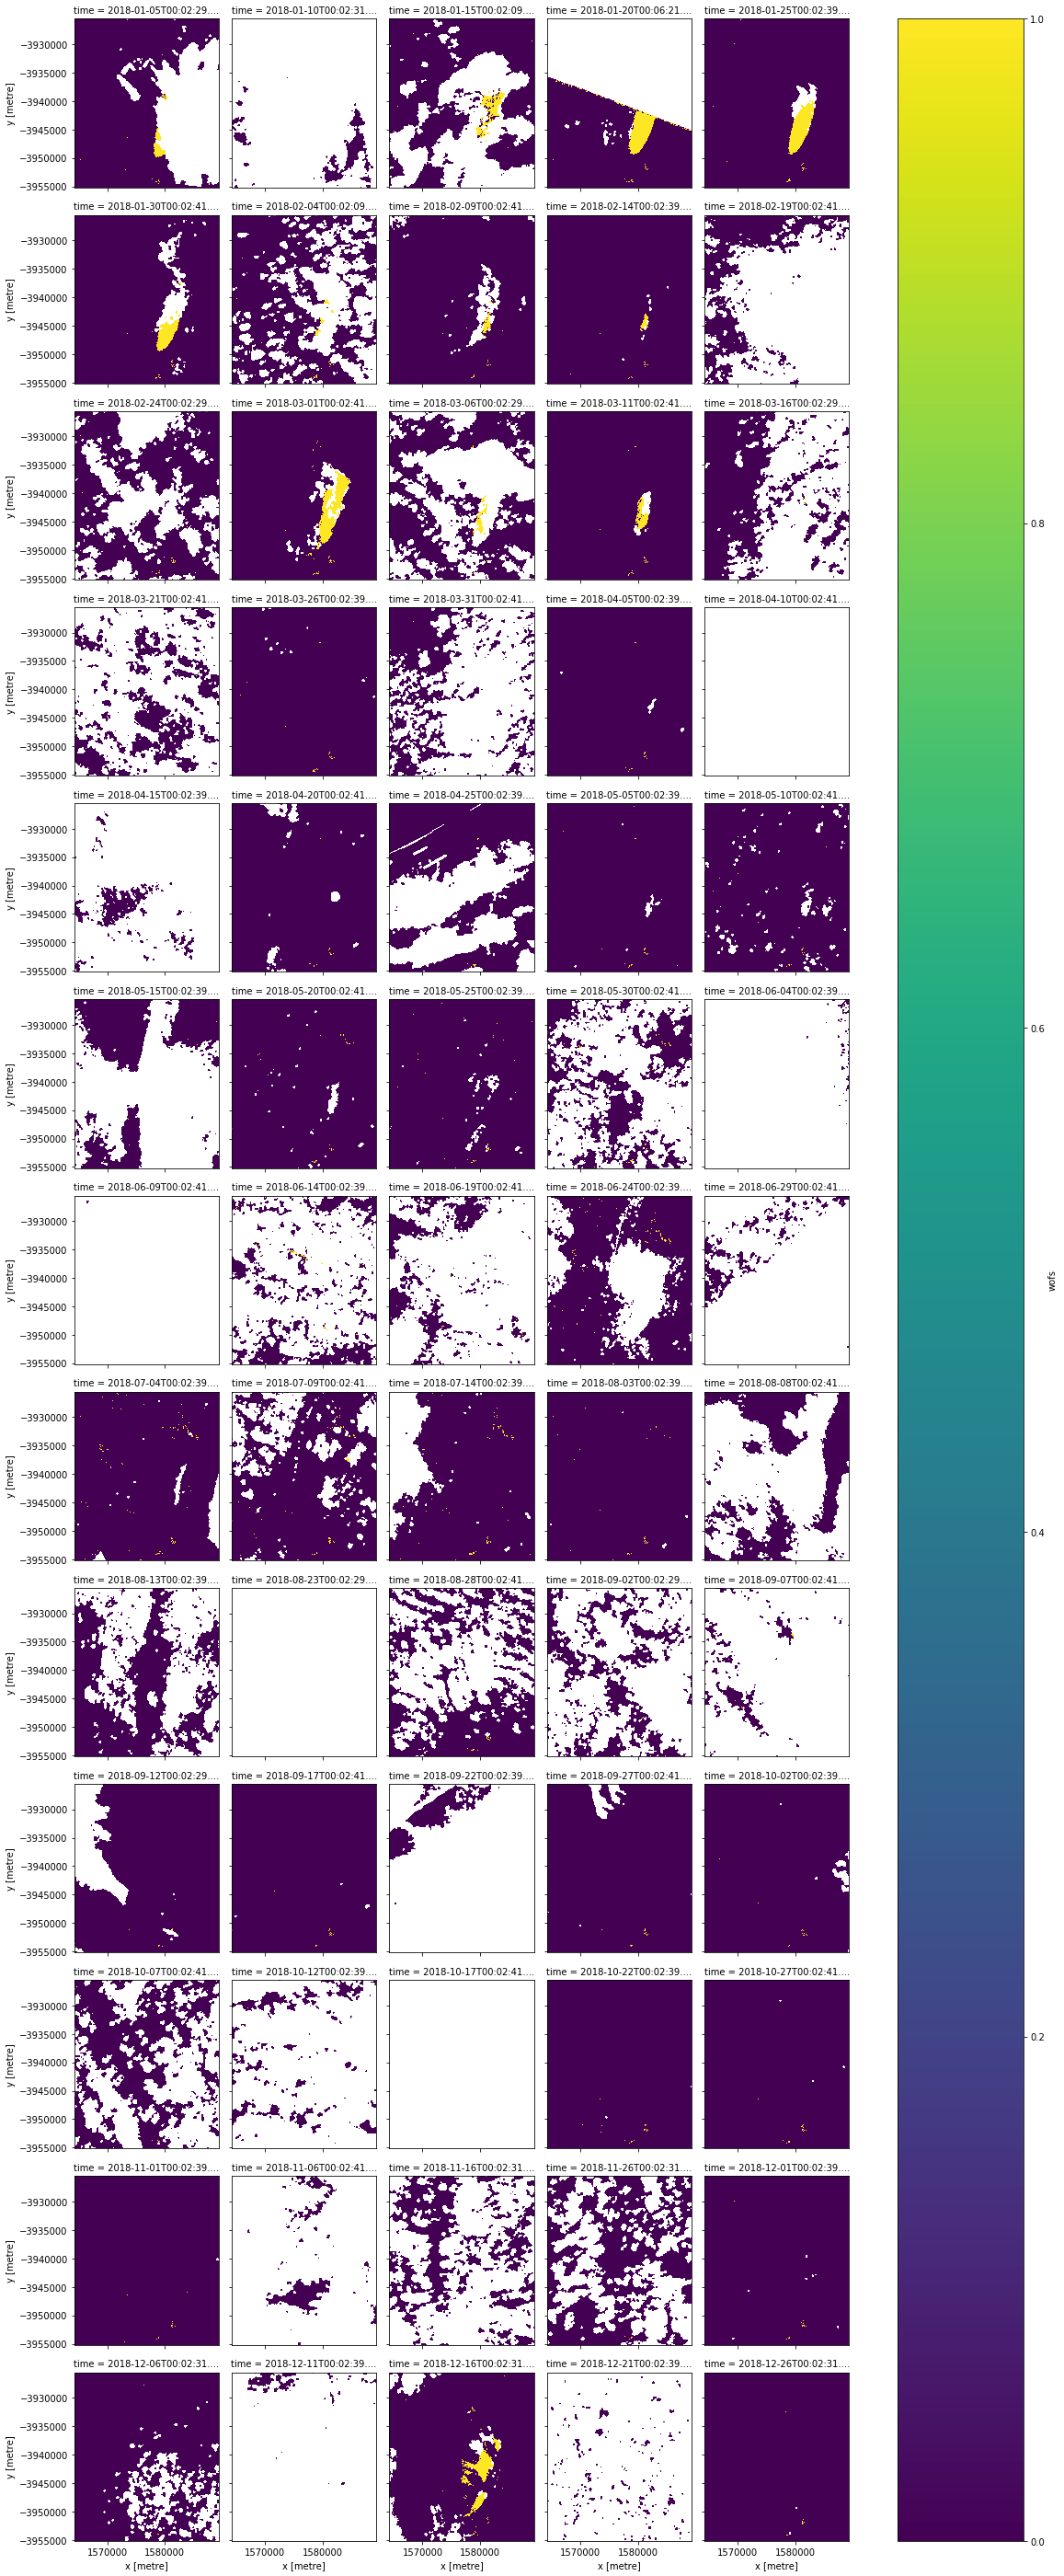

In [25]:
water_classes.wofs.plot(col='time', col_wrap=5)

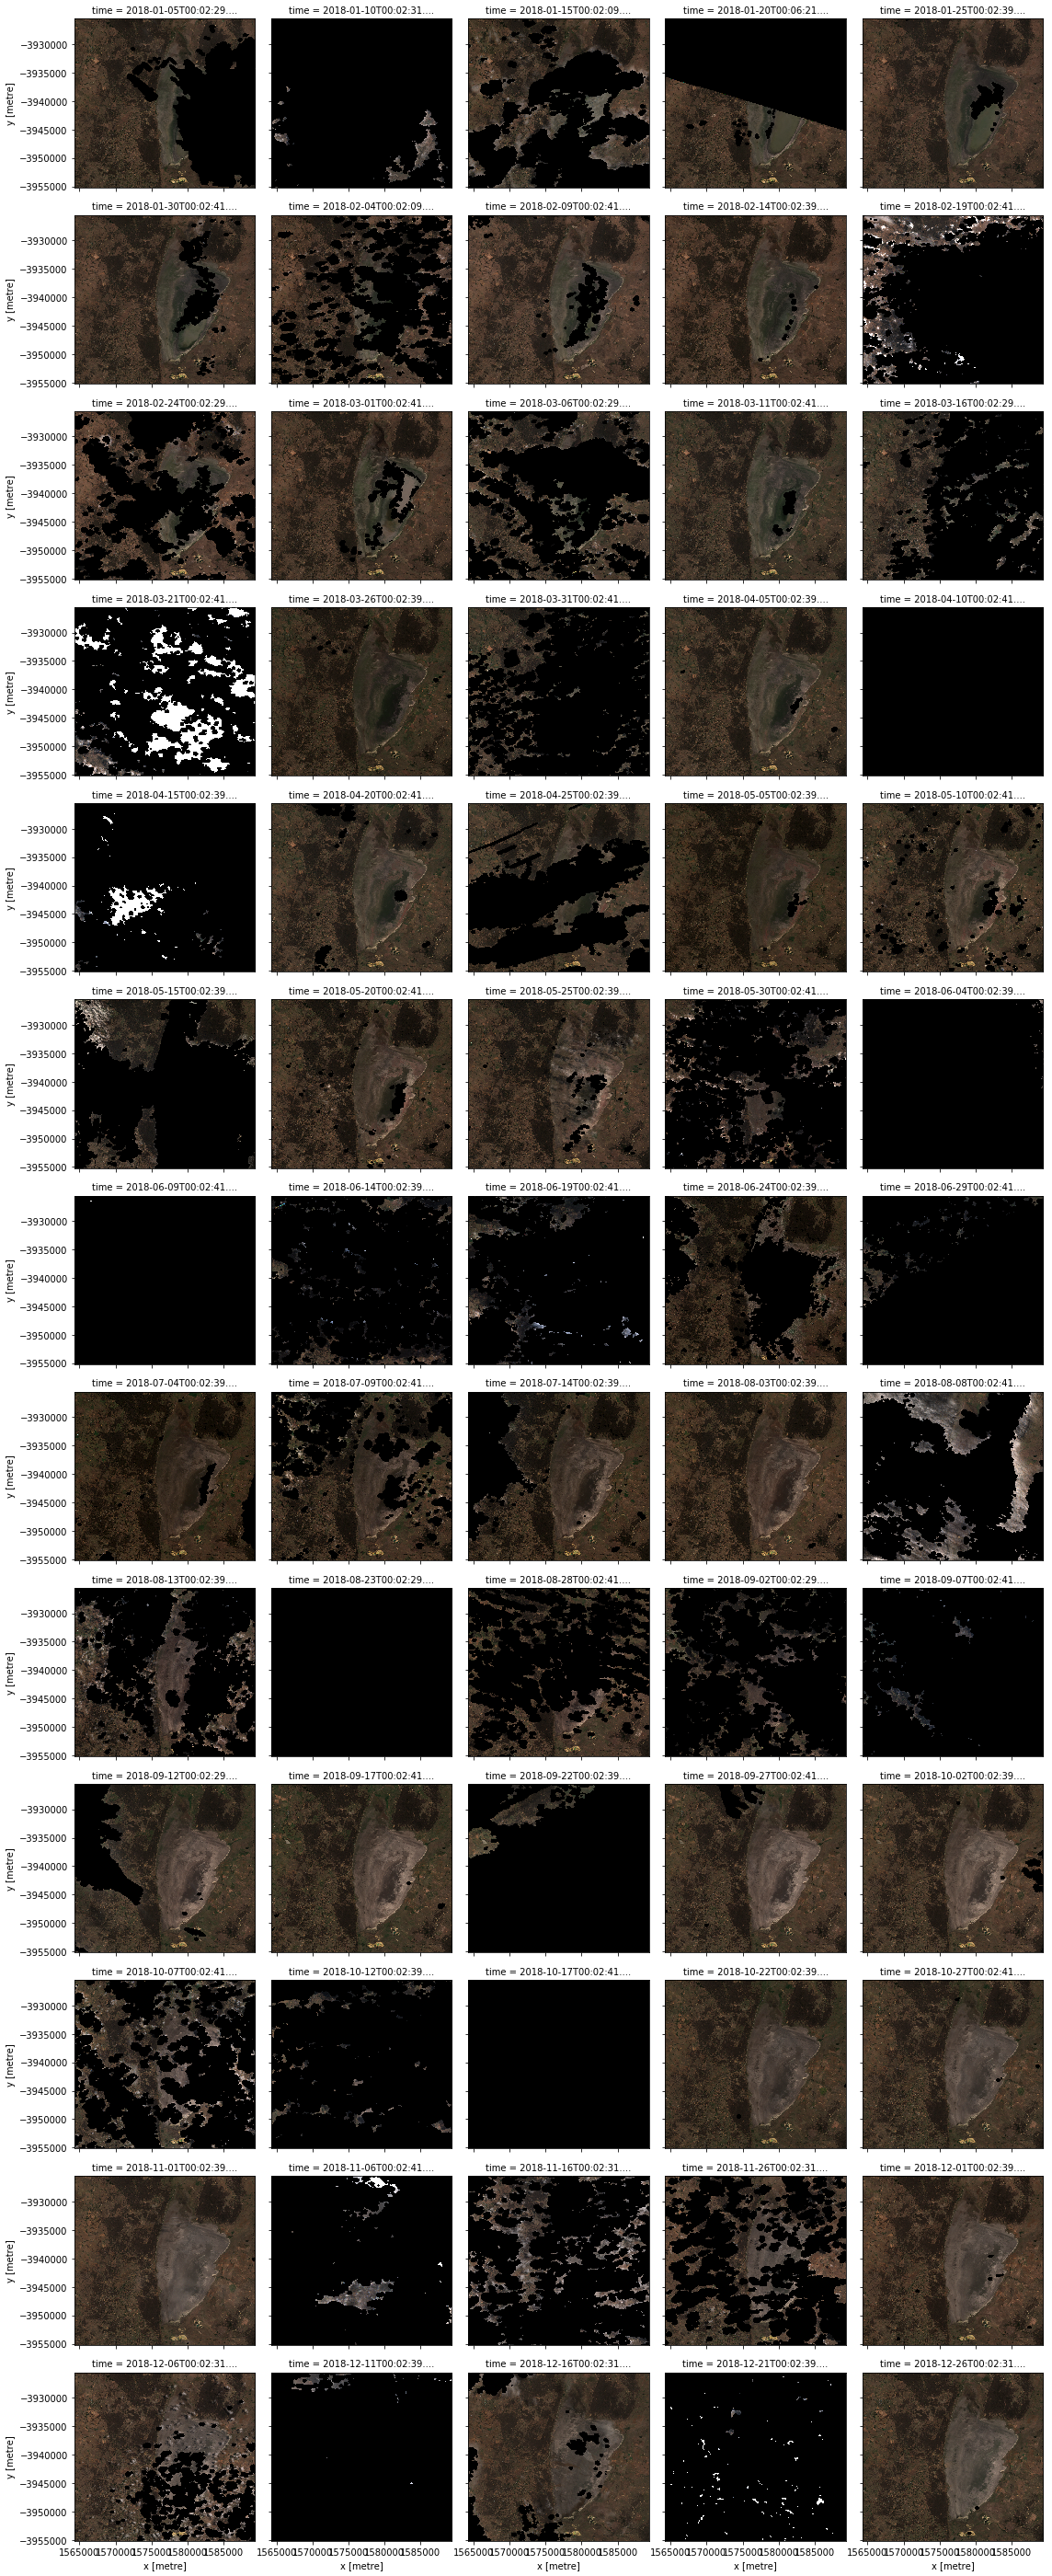

In [26]:
scenes[['red','green','blue']].to_array().where(clean_mask,0).plot.imshow(col='time',col_wrap=5, 
                                                                          vmin=0, vmax=4000)

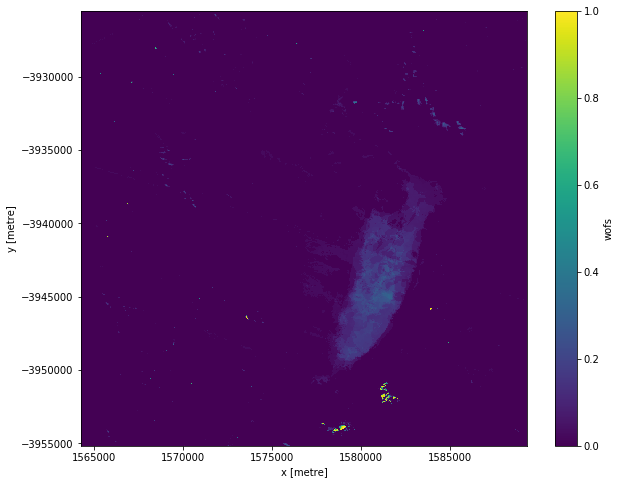

In [27]:
plt.figure(figsize = (10,8))
water_classes.wofs.mean(dim = 'time').plot()

In [28]:
# Ensure the output directory exists before writing to it.
output_file_name  =  "output/wofs_s2ab_cloudless_2018.nc"

In [29]:
water_classes

<xarray.Dataset>
Dimensions:  (time: 65, x: 836, y: 988)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-05T00:02:29.027000 ... 2018-12-26T00:02:31.024000
  * y        (y) float64 -3.955e+06 -3.955e+06 ... -3.926e+06 -3.926e+06
  * x        (x) float64 1.564e+06 1.564e+06 1.564e+06 ... 1.589e+06 1.589e+06
Data variables:
    wofs     (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [30]:
scenes.attrs

OrderedDict([('crs', CRS('EPSG:3577'))])

In [31]:
dataset_to_output =  water_classes.assign_attrs(scenes.attrs)
datacube.storage.storage.write_dataset_to_netcdf(dataset_to_output, output_file_name)

INFO:datacube.storage.storage:Creating storage unit: output/wofs_s2ab_cloudless_2018.nc


In [ ]:
!ls output/